# Sales Forecasting

Walmart has been having trouble figuring out how much to buy to restock its products and optimize sales. On the last important dates for the retail sector, the team had problems with purchasing supplies. In some departments, the purchase was above the expected sales and in others there was a lack of products.

The supply team asked us to help them solve their problem in forecasting demand for each store and each department. The team opted to build a regression model to predict sales and thus help the supply team scale purchases.

# 1.0 Data Catalog

**Dataset - Store**<br>
**Store** - Store IDs <br>
**Type** - Store types <br>
**Size** - Store sizes <br> <br>

**Dataset - Features**<br>
**Store** - Store IDs <br>
**Date** - The week <br>
**Temperature** - Average temperature in the region <br>
**Fuel Price** - Cost of fuel in region <br>
**MarkDown 1-5** - Anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA <br>
**CPI** - The customer price index <br>
**Unemployment** - The unemployment rate <br>
**IsHoliday** - Whether the week is a especial holiday week <br>
 <br>

**Dataset - Train/Test**<br>
**Store** - Store IDs <br>
**Dept** - Departament <br>
**Weekly_sales** - Weekly Sales <br>
**Date** - The first date of the week <br>
**IsHoliday** - True or False <br><br>


For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

**Super Bowl:**  <br>
    - 12-Feb-10 <br>
    - 11-Feb-11 <br>
    - 10-Feb-12 <br>
    - 8-Feb-13 <br>
**Labor Day:**  <br>
    - 10-Sep-10 <br>
    - 9-Sep-11 <br>
    - 7-Sep-12 <br>
    - 6-Sep-13 <br>
**Thanksgiving:**  <br>
    - 26-Nov-10 <br>
    - 25-Nov-11 <br>
    - 23-Nov-12 <br>
    - 29-Nov-13 <br>
**Christmas:**  <br>
    - 31-Dec-10 <br>
    - 30-Dec-11 <br>
    - 28-Dec-12 <br>
    - 27-Dec-13 <br>

# 2.0 Libraries

In [89]:
import pandas as pd
import pandasql as ps
import numpy as np
import datetime


import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from IPython.display import Image



from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler)
from category_encoders import TargetEncoder
# from feature_engine import transformation as vt
# from feature_engine.transformation import AddFeature

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_squared_error)

In [2]:
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

# 3.0 Loading Data

In [3]:
df_features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
df_stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_raw = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv')
df_raw.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 3.1 Join

In [6]:
query = """
    SELECT df.Store,
           df.Dept,
           df.Date,
           df.Weekly_Sales,
           df.IsHoliday,
           stores.Type,
           stores.Size,
           features.Temperature,
           features.Fuel_Price,
           features.MarkDown1,
           features.MarkDown2,
           features.MarkDown3,
           features.MarkDown4,
           features.MarkDown5,
           features.CPI,
           features.Unemployment
    FROM df_raw df
    LEFT JOIN df_stores stores
    ON stores.Store = df.Store 
    LEFT JOIN df_features features
    ON features.Store = df.Store AND features.Date = df.Date;
"""
df = ps.sqldf(query)

## 3.2 Split Data

Since we want to predict weekly sales, it's better to split our data by date instead of train_test_split. In this way, we can simulate the actual data in production

In [7]:
print(f"Shape: {df.shape}")
df.groupby('Date').size()

Shape: (421570, 16)


Date
2010-02-05    2955
2010-02-12    2956
2010-02-19    2977
2010-02-26    2951
2010-03-05    2944
              ... 
2012-09-28    2962
2012-10-05    2976
2012-10-12    2990
2012-10-19    2950
2012-10-26    2959
Length: 143, dtype: int64

In [8]:
df_temp_ordered = df.sort_values('Date', ascending = True)

cutoff_date = df_temp_ordered[: int(df_temp_ordered.shape[0] * 0.7)][['Date']].max()[0]

df_train_raw = df_temp_ordered[df_temp_ordered.Date <= cutoff_date]
df_test_raw = df_temp_ordered[df_temp_ordered.Date > cutoff_date]

In [9]:
print(f"df_train_raw: {df_train_raw.shape}")
print(f"df_test_raw: {df_test_raw.shape}")

df_train_raw: (297105, 16)
df_test_raw: (124465, 16)


In [10]:
df_train_raw.Date.max()

'2012-01-06'

In [11]:
df_test_raw.Date.min()

'2012-01-13'

# 4.0 Descriptive Analisys

In [12]:
df_train_desc = df_train_raw.copy()
df_test_desc = df_test_raw.copy()

In [13]:
df_train_desc

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
277665,29,5,2010-02-05,15552.08,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064
277808,29,6,2010-02-05,3200.22,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064
277951,29,7,2010-02-05,10820.05,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064
278094,29,8,2010-02-05,20055.64,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162232,17,35,2012-01-06,1235.32,0,B,93188,27.64,3.080,5185.45,12090.50,33.90,1490.06,4832.68,130.157516,6.403
294233,31,4,2012-01-06,38387.63,0,A,203750,48.10,3.157,6105.78,25953.41,91.69,1254.60,6256.02,219.355063,7.057
104287,11,54,2012-01-06,104.36,0,A,207499,54.44,3.157,5107.29,32305.30,144.66,530.55,6004.19,223.192305,6.833
242947,25,46,2012-01-06,15599.22,0,B,128107,30.23,3.422,8642.20,26833.97,25.94,1092.98,3714.33,212.571112,6.961


We have missing value in MarkDown features

In [14]:
df_train_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297105 entries, 0 to 23700
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         297105 non-null  int64  
 1   Dept          297105 non-null  int64  
 2   Date          297105 non-null  object 
 3   Weekly_Sales  297105 non-null  float64
 4   IsHoliday     297105 non-null  int64  
 5   Type          297105 non-null  object 
 6   Size          297105 non-null  int64  
 7   Temperature   297105 non-null  float64
 8   Fuel_Price    297105 non-null  float64
 9   MarkDown1     26673 non-null   float64
 10  MarkDown2     23127 non-null   float64
 11  MarkDown3     26089 non-null   float64
 12  MarkDown4     23668 non-null   float64
 13  MarkDown5     26967 non-null   float64
 14  CPI           297105 non-null  float64
 15  Unemployment  297105 non-null  float64
dtypes: float64(10), int64(4), object(2)
memory usage: 38.5+ MB


In [15]:
df_test_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124465 entries, 357833 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         124465 non-null  int64  
 1   Dept          124465 non-null  int64  
 2   Date          124465 non-null  object 
 3   Weekly_Sales  124465 non-null  float64
 4   IsHoliday     124465 non-null  int64  
 5   Type          124465 non-null  object 
 6   Size          124465 non-null  int64  
 7   Temperature   124465 non-null  float64
 8   Fuel_Price    124465 non-null  float64
 9   MarkDown1     124008 non-null  float64
 10  MarkDown2     88121 non-null   float64
 11  MarkDown3     111002 non-null  float64
 12  MarkDown4     111299 non-null  float64
 13  MarkDown5     124465 non-null  float64
 14  CPI           124465 non-null  float64
 15  Unemployment  124465 non-null  float64
dtypes: float64(10), int64(4), object(2)
memory usage: 16.1+ MB


In [16]:
# Unique Values
df_train_desc.nunique()

Store               45
Dept                81
Date               101
Weekly_Sales    259273
IsHoliday            2
Type                 3
Size                40
Temperature       2755
Fuel_Price         681
MarkDown1          398
MarkDown2          318
MarkDown3          384
MarkDown4          336
MarkDown5          405
CPI               1515
Unemployment       262
dtype: int64

We already knew that Markdown columns had no data before 2011

In [17]:
# Missing Values
df_train_desc.isnull().sum().sort_values(ascending = False)

MarkDown2       273978
MarkDown4       273437
MarkDown3       271016
MarkDown1       270432
MarkDown5       270138
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
dtype: int64

### Numerical Features

IsHoliday feature has almost zero variance. Let's check futher to understand wether we should disregarding it

In [18]:
kurt = pd.DataFrame(df_train_desc.select_dtypes(include = ['int64', 'float64']).apply(lambda x: x.kurtosis())).T
skew = pd.DataFrame(df_train_desc.select_dtypes(include = ['int64', 'float64']).apply(lambda x: x.skew())).T
variance = pd.DataFrame(df_train_desc.select_dtypes(include = ['int64', 'float64']).var().round(2)).applymap(lambda x: "{:.{}f}".format(x, 2) if isinstance(x, (float)) else x).T
desc = pd.DataFrame(df_train_desc.describe())


df_stats = pd.concat([desc,  kurt, skew, variance]).T.reset_index()
df_stats.columns = ['atributos','count', 'mean', 'std','min', '25%', '50%', '75%', 'max', 'kurtosis', 'skew', 'variance']
df_stats

,atributos,count,mean,std,min,25%,50%,75%,max,kurtosis,skew,variance
0,Store,297105.0,22.180374,12.780341,1.0,11.0,22.0,33.0,45.0,-1.145159,0.078928,163.34
1,Dept,297105.0,44.184702,30.430357,1.0,18.0,37.0,72.0,99.0,-1.211019,0.359123,926.01
2,Weekly_Sales,297105.0,16095.459685,22958.21937,-4988.94,2140.71,7716.25,20333.65,693099.36,25.342276,3.43792,527079836.62
3,IsHoliday,297105.0,0.07975,0.270906,0.0,0.0,0.0,0.0,1.0,7.62606,3.102581,0.07
4,Size,297105.0,136883.394786,60919.579093,34875.0,93638.0,140167.0,202505.0,219622.0,-1.201558,-0.329216,3711195116.87
5,Temperature,297105.0,58.724823,18.960051,-2.06,45.12,60.11,73.19,100.14,-0.708775,-0.235769,359.48
6,Fuel_Price,297105.0,3.210581,0.43734,2.472,2.808,3.129,3.594,4.211,-1.188876,0.288683,0.19
7,MarkDown1,26673.0,4590.792344,5044.766647,0.5,824.88,3581.98,6176.69,34348.14,9.881911,2.616881,25449670.52
8,MarkDown2,23127.0,9702.438261,18419.060929,0.0,47.0,286.0,11652.84,104519.54,6.51342,2.458179,339261805.49
9,MarkDown3,26089.0,7331.579834,21063.965527,-0.87,95.01,292.36,1079.89,141630.61,11.249623,3.348956,443690643.74


The stores have similar distribuition

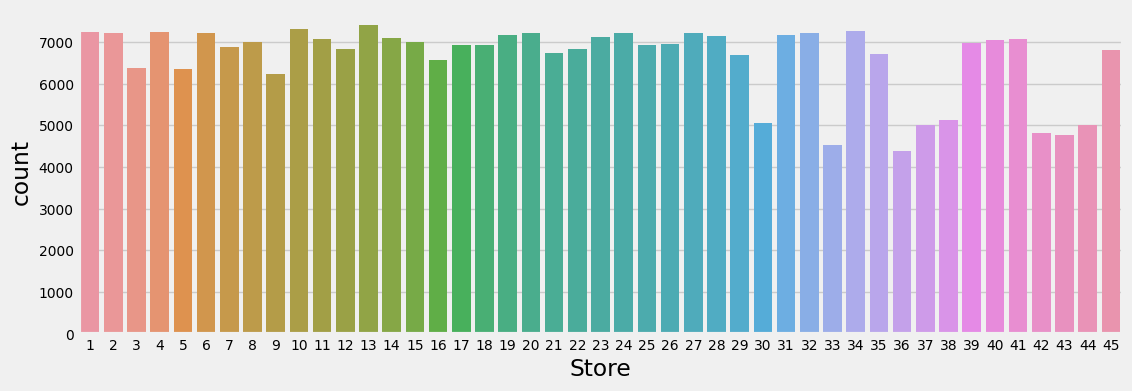

In [19]:
ax = sns.countplot(x = "Store", data = df_train_desc, orient = 'h')
ax.figure.set_size_inches(12, 4)

# 5.0 EDA (Exploratory Data Analysis)

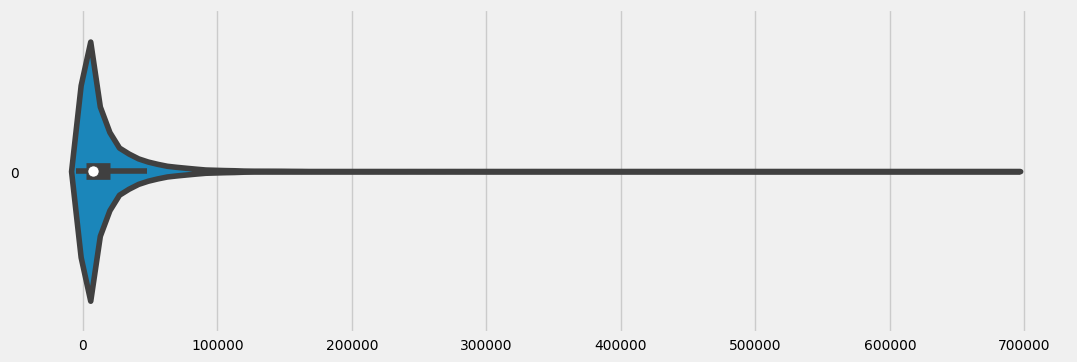

In [43]:
ax = sns.violinplot(df_train_desc['Weekly_Sales'], orient = 'h')
ax.figure.set_size_inches(12, 4)
plt.show()

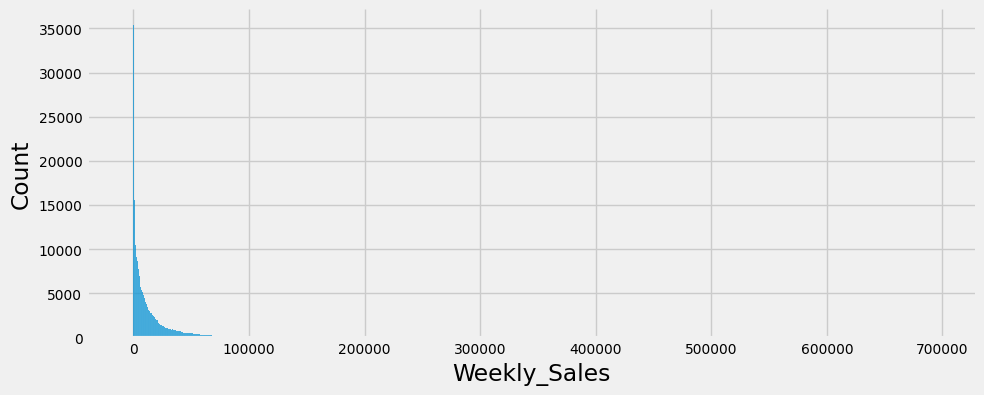

In [20]:
ax = sns.displot(df_train_desc['Weekly_Sales'])
ax.figure.set_size_inches(12, 4)
plt.show()

The data distribution is very similar on holidays and on normal days. But it is possible to notice that there are some days on holidays that sales skyrocketed.

[Text(0.5, 1.0, 'Boxplot Weekly_Sales'), Text(0.5, 0, 'Weekly_Sales')]

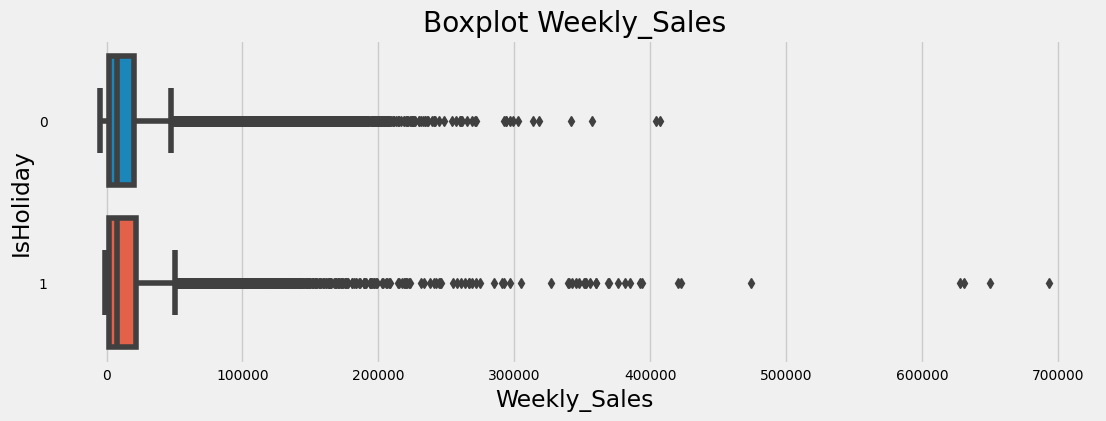

In [21]:
ax = sns.boxplot(x = "Weekly_Sales", y = 'IsHoliday', data = df_train_desc, orient = 'h')
ax.figure.set_size_inches(12, 4)
ax.set(title = 'Boxplot Weekly_Sales', xlabel = 'Weekly_Sales')

Week_Sales x Size <br>
    
 - As expected, the larger the store, the greater the sales.
 - Almost all of the stores sold more when there was a holiday, Is specific holiday the best?

 - What If I created dummies variables with the holiday type?"

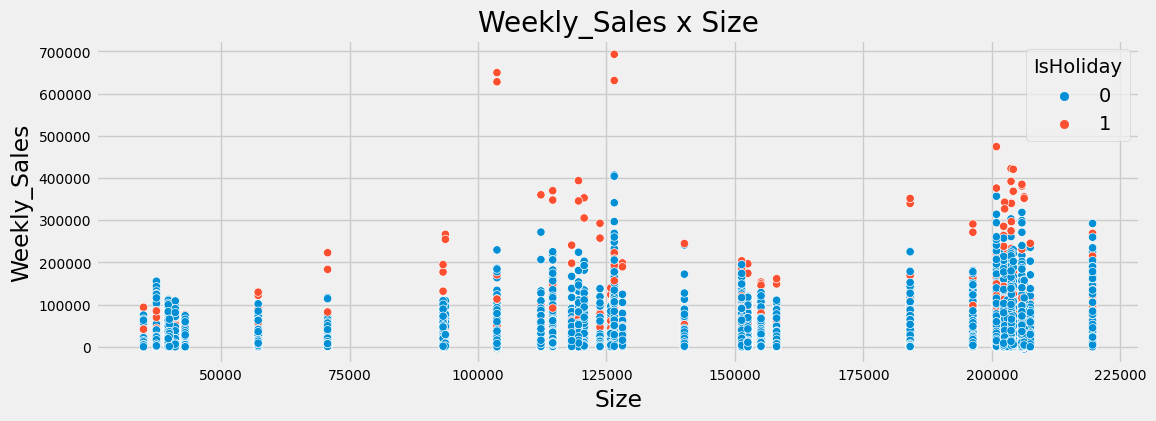

In [22]:
ax = sns.scatterplot(x = "Size", y = 'Weekly_Sales', hue = "IsHoliday", data = df_train_desc)
ax.figure.set_size_inches(12, 4)
ax.set(title = 'Weekly_Sales x Size')
plt.show()

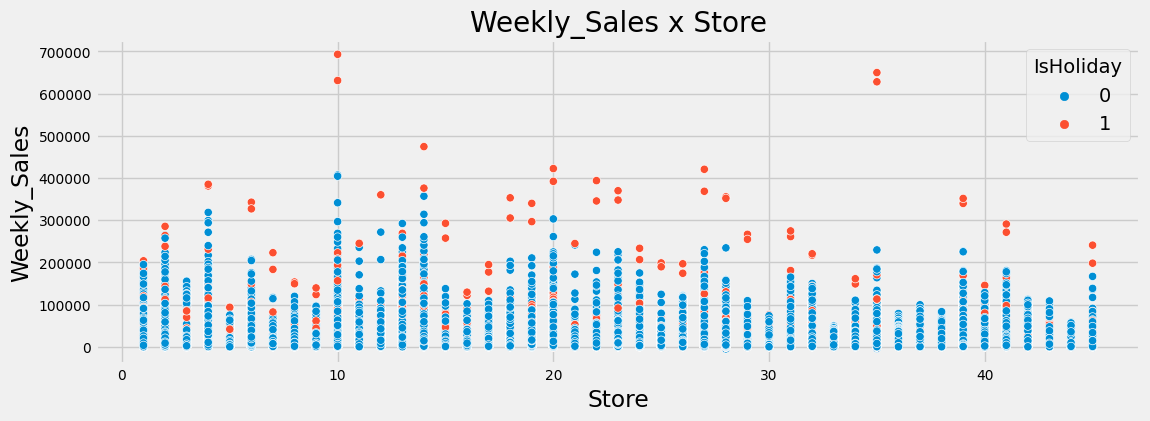

In [23]:
ax = sns.scatterplot(x = "Store", y = 'Weekly_Sales', hue = "IsHoliday", data = df_train_desc)
ax.figure.set_size_inches(12, 4)
ax.set(title = 'Weekly_Sales x Store')
plt.show()

Week Sales x  Temperature

In mild temperatures, we had the biggest sales

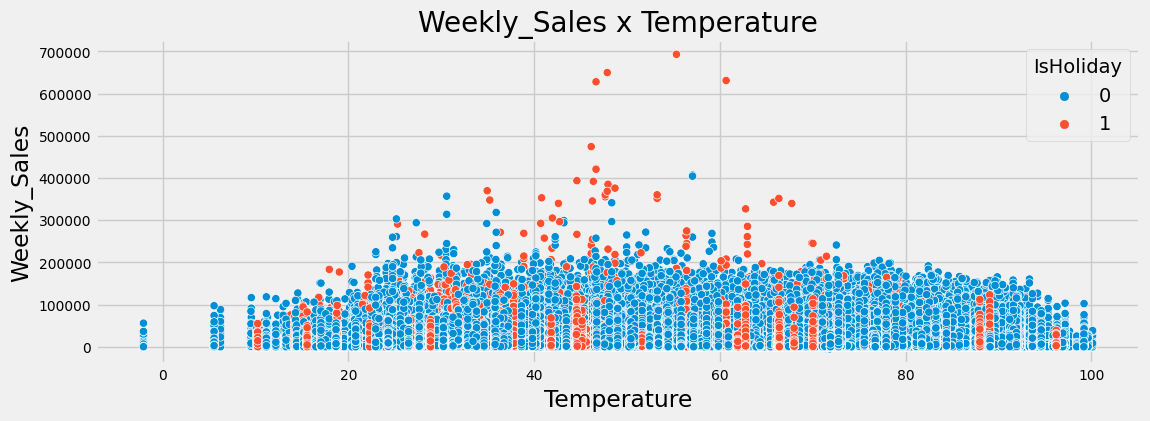

In [24]:
ax = sns.scatterplot(x = "Temperature", y = 'Weekly_Sales', hue = "IsHoliday", data = df_train_desc)
ax.figure.set_size_inches(12, 4)
ax.set(title = 'Weekly_Sales x Temperature')
plt.show()

Fuel Price

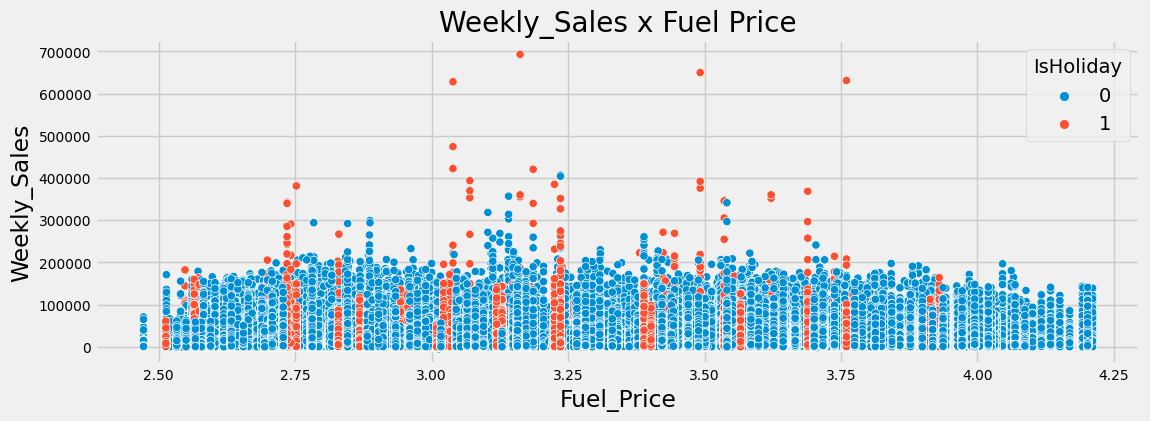

In [25]:
ax = sns.scatterplot(x = "Fuel_Price", y = 'Weekly_Sales', hue = "IsHoliday", data = df_train_desc)
ax.figure.set_size_inches(12, 4)
ax.set(title = 'Weekly_Sales x Fuel Price')
plt.show()

Unemployment <br>

As expected, when we a have higher unemployment we have less sales

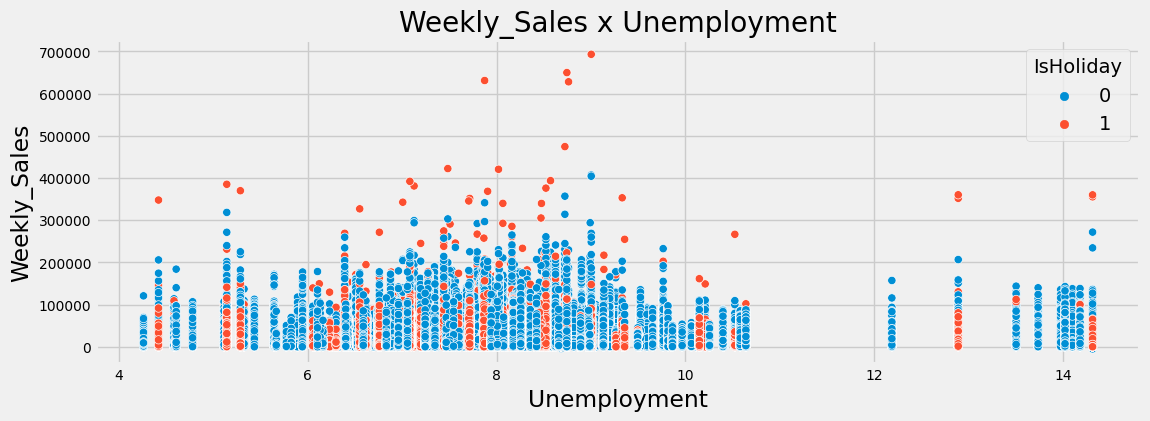

In [26]:
ax = sns.scatterplot(x = "Unemployment", y = 'Weekly_Sales', hue = "IsHoliday", data = df_train_desc)
ax.figure.set_size_inches(12, 4)
ax.set(title = 'Weekly_Sales x Unemployment')
plt.show()

Correlation

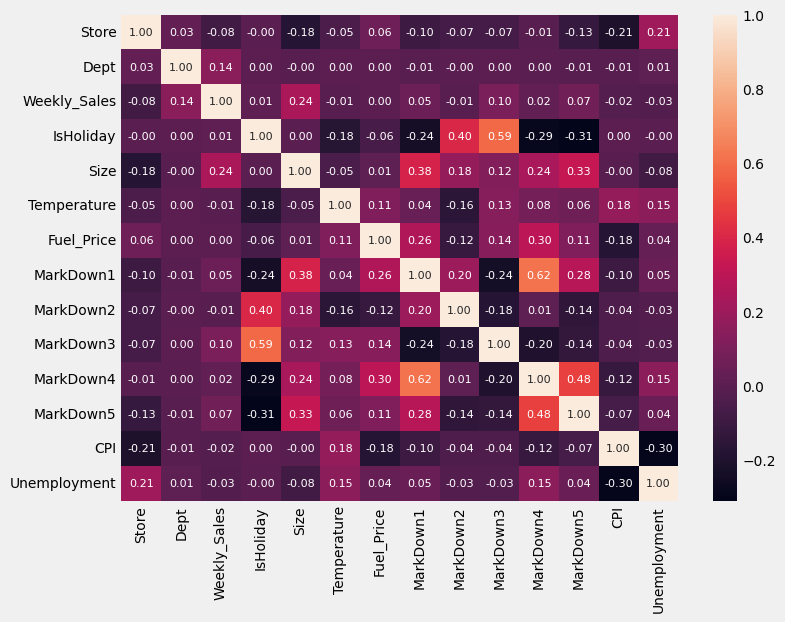

In [27]:
ax = plt.figure(figsize = (8, 6))

col_corr = df_train_desc.drop(['Type', 'Date'], axis = 1).columns

corr = df_train_desc[col_corr].corr(method = "pearson")

sns.heatmap(corr, annot = True, fmt = '.2f', annot_kws={"size": 8})
plt.show()

# 6.0 Feature Engineering

In [56]:
df_train_feen = df_train_raw.copy()
df_test_feen = df_test_raw.copy()

Almost half of data in Markdown columns have missing values, so we're excluding those columns

In [57]:
df_train_feen.shape

(297105, 16)

In [58]:
df_train_feen.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270432
MarkDown2       273978
MarkDown3       271016
MarkDown4       273437
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

**Baseline Model**

In [59]:
col_drop = ['Weekly_Sales', 'Date', 'Type', 'Store', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

X_train = df_train_feen.drop(col_drop, axis = 1).values
X_test = df_test_feen.drop(col_drop, axis = 1).values
y_train = df_train_feen['Weekly_Sales']
y_test = df_test_feen['Weekly_Sales']

# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)
y_pred = baseline_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


R2 Score: 0.08914928942029388
MAE: 14537.929709960415
MSE: 445189012.2290937
RMSE: 21099.50265359574


### Variable: Type

We're going to use Target Enconding to transform Categorical -> Numerical

In [60]:
df_train_feen.groupby('Type').size()

Type
A    152077
B    115264
C     29764
dtype: int64

In [61]:
df_te_1 = df_train_feen[['Type', 'Weekly_Sales']]
df_te_2 = df_test_feen[['Type']]

target_encoder = TargetEncoder(cols = ['Type'])

df_train_feen['Type_targetEncoder']  = target_encoder.fit_transform(df_te_1.Type, df_te_1.Weekly_Sales)
df_train_feen.Type_targetEncoder.value_counts()


Type_targetEncoder
20203.323404    152077
12381.169521    115264
9490.579651      29764
Name: count, dtype: int64

In [62]:
df_test_feen['Type_targetEncoder']  = target_encoder.transform(df_te_2.Type)
df_test_feen.Type_targetEncoder.value_counts()

Type_targetEncoder
20203.323404    63401
12381.169521    48231
9490.579651     12833
Name: count, dtype: int64

### Variable: Date

We'll create numeric column

In [63]:
df_train_feen["Date_numeric"] = df_train_feen["Date"].apply(lambda x: int(x.replace("-", "")))
df_train_feen

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_targetEncoder,Date_numeric
0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,20203.323404,20100205
277665,29,5,2010-02-05,15552.08,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,12381.169521,20100205
277808,29,6,2010-02-05,3200.22,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,12381.169521,20100205
277951,29,7,2010-02-05,10820.05,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,12381.169521,20100205
278094,29,8,2010-02-05,20055.64,0,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,12381.169521,20100205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162232,17,35,2012-01-06,1235.32,0,B,93188,27.64,3.080,5185.45,12090.50,33.90,1490.06,4832.68,130.157516,6.403,12381.169521,20120106
294233,31,4,2012-01-06,38387.63,0,A,203750,48.10,3.157,6105.78,25953.41,91.69,1254.60,6256.02,219.355063,7.057,20203.323404,20120106
104287,11,54,2012-01-06,104.36,0,A,207499,54.44,3.157,5107.29,32305.30,144.66,530.55,6004.19,223.192305,6.833,20203.323404,20120106
242947,25,46,2012-01-06,15599.22,0,B,128107,30.23,3.422,8642.20,26833.97,25.94,1092.98,3714.33,212.571112,6.961,12381.169521,20120106


In [64]:
df_test_feen["Date_numeric"] = df_test_feen["Date"].apply(lambda x: int(x.replace("-", "")))
df_test_feen

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_targetEncoder,Date_numeric
357833,38,49,2012-01-13,8.91,0,C,39690,48.07,3.657,1129.45,125.33,31.85,NaN,1101.74,130.244000,12.187,9490.579651,20120113
261855,27,37,2012-01-13,2264.84,0,A,204184,41.30,3.666,8081.05,16237.87,542.46,643.15,6238.31,140.704821,8.009,20203.323404,20120113
326958,34,52,2012-01-13,882.14,0,A,158114,33.99,3.263,2514.23,8431.82,48.38,186.59,4699.39,130.244000,9.653,20203.323404,20120113
119280,13,12,2012-01-13,5727.17,0,A,219622,25.61,3.056,3627.07,14887.88,119.93,798.48,4668.82,130.244000,6.104,20203.323404,20120113
298935,31,38,2012-01-13,90157.83,0,A,203750,45.00,3.261,4371.53,14136.14,54.52,719.85,3942.03,219.532820,7.057,20203.323404,20120113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379648,40,87,2012-10-26,24638.96,0,A,155083,49.65,3.917,3605.71,55.98,0.28,486.81,1389.06,138.728161,4.145,20203.323404,20121026
181170,19,30,2012-10-26,3740.12,0,A,203819,56.49,4.071,5430.75,90.07,NaN,904.34,1665.77,138.728161,7.992,20203.323404,20121026
181313,19,31,2012-10-26,3128.17,0,A,203819,56.49,4.071,5430.75,90.07,NaN,904.34,1665.77,138.728161,7.992,20203.323404,20121026
181599,19,33,2012-10-26,5740.14,0,A,203819,56.49,4.071,5430.75,90.07,NaN,904.34,1665.77,138.728161,7.992,20203.323404,20121026


### Variable: IsHoliday

We'll create four booleans columns for each holiday

In [69]:
super_bowl = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_day = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
thanksgiving = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
christimas = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

def func_holiday(date):
        if (date in super_bowl):
            return "super_bowl"
        elif (date in labor_day):
            return "labor_day"
        elif (date in thanksgiving):
            return "thanksgiving"
        elif (date in christimas):
            return "christimas"
        else:
            return 0


df_train_feen["holiday_name"] = df_train_feen["Date"].apply(lambda x: func_holiday(x))
df_test_feen["holiday_name"] = df_test_feen["Date"].apply(lambda x: func_holiday(x))

df_train_feen.groupby("holiday_name").size()

holiday_name
0               273411
christimas        5946
labor_day         5895
super_bowl        5894
thanksgiving      5959
dtype: int64

In [70]:
df_test_feen.groupby("holiday_name").size()

holiday_name
0             118498
labor_day       2966
super_bowl      3001
dtype: int64

In [81]:
df_te_1 = df_train_feen[['holiday_name', 'Weekly_Sales']]
df_te_2 = df_test_feen[['holiday_name']]

target_encoder = TargetEncoder(cols = ['holiday_name'])

df_train_feen['holiday_targetEncoder']  = target_encoder.fit_transform(df_te_1.holiday_name, df_te_1.Weekly_Sales)
df_train_feen.holiday_targetEncoder.value_counts()


holiday_targetEncoder
16001.848738    273411
22220.944538      5959
14543.387158      5946
15673.897433      5895
16232.248120      5894
Name: count, dtype: int64

In [80]:
df_test_feen['holiday_targetEncoder']  = target_encoder.transform(df_te_2.holiday_name)
df_test_feen.holiday_targetEncoder.value_counts()

holiday_targetEncoder
16001.848738    118498
16232.248120      3001
15673.897433      2966
Name: count, dtype: int64

# 7.0 Models

In [112]:
cols_to_drop = ['Date', 'Type', 'Store', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', "IsHoliday", "holiday_name"]

df_train_pre = df_train_feen.drop(cols_to_drop, axis=1).copy()
df_test_pre = df_test_feen.drop(cols_to_drop, axis=1).copy()

X_train = df_train_pre.drop("Weekly_Sales", axis=1)
y_train = df_train_pre["Weekly_Sales"]
X_test = df_test_pre.drop("Weekly_Sales", axis=1)
y_test = df_test_pre["Weekly_Sales"]

In [113]:

numerical_transformer = Pipeline(steps=[
    ("scalar", StandardScaler())
])
numerical_features = df_train_pre.drop("Weekly_Sales", axis=1).columns

preprocessor = ColumnTransformer(transformers = [
    ("num", numerical_transformer, numerical_features)
])


xgb = XGBRegressor()

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

R2 Score: 0.8962968164701598
MAE: 4337.200308523824
MSE: 50686152.30181782
RMSE: 7119.420784152165


# WIP